In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import relativedelta
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager
import ast

DATA_PATH = Path('/home/engaclew/neurogen')

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
lena_measures = pd.read_csv(DATA_PATH / 'lena_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Compute age and retrieve group_id information
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'date_iso', 'recording_filename', 'child_sex', 'child_dob']]
def diff_month(row):
    d1 = datetime.strptime(row['date_iso'], '%Y-%m-%d')
    d2 = datetime.strptime(row['child_dob'], '%Y-%m-%d')
    return (d1.year - d2.year) * 12 + d1.month - d2.month
recordings_data['age'] = recordings_data.apply(lambda row: diff_month(row), axis=1)

aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
lena_measures = lena_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')

# Merge pitch from speech-like and non-speech-like vocalizatiojns
def clean_pitch_concatenation(df):
    def safe_eval(x):
        if pd.isna(x):
            return []
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []
    df['speechlike_pitch'] = df['speechlike_pitch'].apply(safe_eval)
    df['nonspeechlike_pitch'] = df['nonspeechlike_pitch'].apply(safe_eval)
    df['pitch'] = df.apply( lambda row: row['speechlike_pitch'] + row['nonspeechlike_pitch'],  axis=1)
    return df
    
aclew_measures = clean_pitch_concatenation(aclew_measures)
lena_measures = clean_pitch_concatenation(lena_measures)
human_measures = clean_pitch_concatenation(human_measures)

# Compute CVC
def compute_CVC(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    return data

aclew_measures = compute_CVC(aclew_measures)
human_measures = compute_CVC(human_measures)

# Group per child
def group_clips(df):
    
    # Define aggregation rules for each column
    agg_rules = {
        'group_id': 'first',
        'child_id': 'first',
        'avg_voc_dur_chi': 'mean',
        'CVC': 'sum',
        'wc_adu': 'sum',
        '5s_CTC': 'sum',
        'pitch': 'sum'
    }
    
    # Group by recording_filename and apply aggregations
    grouped = df.groupby('recording_filename').agg(agg_rules).reset_index()
    
    return grouped

aclew_measures = group_clips(aclew_measures)
lena_measures = group_clips(lena_measures)
human_measures = group_clips(human_measures)

# Compute statistics from pitch
def compute_pitch_statistics(df):
    df['median_pitch'] = df['pitch'].map(lambda x: np.median(x))
    df['first_quart_pitch'] = df['pitch'].map(lambda x:  np.percentile(x, 25))
    df['third_quart_pitch'] = df['pitch'].map(lambda x:  np.percentile(x, 75))
    return df

columns = ['group_id', 'child_id', 'avg_voc_dur_chi', 'CVC', 'wc_adu', '5s_CTC', 'median_pitch', 'first_quart_pitch', 'third_quart_pitch']
aclew_measures = compute_pitch_statistics(aclew_measures)[columns]
lena_measures = compute_pitch_statistics(lena_measures)[columns]
human_measures = compute_pitch_statistics(human_measures)[columns]

In [3]:
# Running diagnostic classifiers
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix

# Dictionary to store all results
results = {
    'ACLEW': {},
    'LENA': {},
    'human': {}
}

def evaluate_measures(X, y, name, feature_names, group_classes=None):
    """
    Parameters:
        X, y, name, feature_names: same as before
        group_classes: if None, keep original classes. 
                      if 'three_groups', combine into low_risk vs sib_asd vs other
    """
    if group_classes == 'three_groups':
        # Create a copy to avoid modifying original labels
        y = y.copy()
        # Combine angelman, down, fragile_x into 'other'
        other_conditions = ['angelman_syndrome', 'down_syndrome', 'fragile_x_syndrome']
        y[np.isin(y, other_conditions)] = 'other'
    
    loo = LeaveOneOut()
    scaler = StandardScaler()
    clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    
    predictions = []
    true_labels = []
    all_coefs = []
    
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        clf.fit(X_train_scaled, y_train)
        pred = clf.predict(X_test_scaled)
        
        predictions.append(pred[0])
        true_labels.append(y_test[0])
        all_coefs.append(clf.coef_)
    
    accuracy = accuracy_score(true_labels, predictions)
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    mean_coefs = np.mean(all_coefs, axis=0)
    importance = np.abs(mean_coefs).sum(axis=0)
    feature_importance = dict(zip(feature_names, importance))
    sorted_importance = dict(sorted(feature_importance.items(), 
                                  key=lambda x: x[1], 
                                  reverse=True))
    
    results[name] = {
        'accuracy': accuracy,
        'predictions': predictions,
        'true_labels': true_labels,
        'confusion_matrix': conf_matrix,
        'unique_labels': np.unique(y),
        'feature_importance': sorted_importance,
        'mean_coefficients': mean_coefs
    }
    
    return results[name]

# Run analysis for each measurement source
for df, name in [(aclew_measures, 'ACLEW'), 
                 (lena_measures, 'LENA'), 
                 (human_measures, 'human')]:
    features = df.drop(['group_id', 'child_id'], axis=1)
    feature_names = features.columns
    X = features.values
    labels = df['group_id'].values
    
    results[name] = evaluate_measures(X, labels, name, feature_names, group_classes=None)
    print(f'Done running {name}.')
    print(f"\nFeature importance for {name}:")
    for feature, imp in results[name]['feature_importance'].items():
        print(f"{feature}: {imp:.3f}")

Done running ACLEW.

Feature importance for ACLEW:
wc_adu: 2.181
third_quart_pitch: 2.044
avg_voc_dur_chi: 2.026
median_pitch: 1.704
first_quart_pitch: 1.588
CVC: 1.494
5s_CTC: 1.249
Done running LENA.

Feature importance for LENA:
avg_voc_dur_chi: 2.468
wc_adu: 2.343
first_quart_pitch: 2.189
CVC: 2.175
third_quart_pitch: 1.631
median_pitch: 1.250
5s_CTC: 0.737
Done running human.

Feature importance for human:
first_quart_pitch: 2.506
CVC: 2.091
wc_adu: 2.030
median_pitch: 1.992
5s_CTC: 1.413
third_quart_pitch: 0.966
avg_voc_dur_chi: 0.760


In [4]:
for key, values in results.items():
    print(f"{key} acc = {values['accuracy']} ({values['accuracy']*len(values['predictions'])} correctly diagnosed)")

nb_groups = len(np.unique(values['predictions']))
chance_acc = 1/nb_groups
print(f"Chance-level acc = {chance_acc} ({len(values['predictions'])/nb_groups} correctly diagnosed)")

ACLEW acc = 0.19230769230769232 (5.0 correctly diagnosed)
LENA acc = 0.19230769230769232 (5.0 correctly diagnosed)
human acc = 0.19230769230769232 (5.0 correctly diagnosed)
Chance-level acc = 0.2 (5.2 correctly diagnosed)


In [5]:
results

{'ACLEW': {'accuracy': 0.19230769230769232,
  'predictions': ['low_risk',
   'autism_sibling',
   'angelman_syndrome',
   'down_syndrome',
   'low_risk',
   'fragile_x_syndrome',
   'down_syndrome',
   'down_syndrome',
   'down_syndrome',
   'angelman_syndrome',
   'angelman_syndrome',
   'fragile_x_syndrome',
   'angelman_syndrome',
   'low_risk',
   'fragile_x_syndrome',
   'autism_sibling',
   'angelman_syndrome',
   'down_syndrome',
   'autism_sibling',
   'low_risk',
   'low_risk',
   'fragile_x_syndrome',
   'down_syndrome',
   'low_risk',
   'angelman_syndrome',
   'down_syndrome'],
  'true_labels': ['low_risk',
   'low_risk',
   'down_syndrome',
   'angelman_syndrome',
   'down_syndrome',
   'low_risk',
   'angelman_syndrome',
   'down_syndrome',
   'angelman_syndrome',
   'angelman_syndrome',
   'down_syndrome',
   'down_syndrome',
   'fragile_x_syndrome',
   'angelman_syndrome',
   'fragile_x_syndrome',
   'fragile_x_syndrome',
   'low_risk',
   'low_risk',
   'autism_sibling

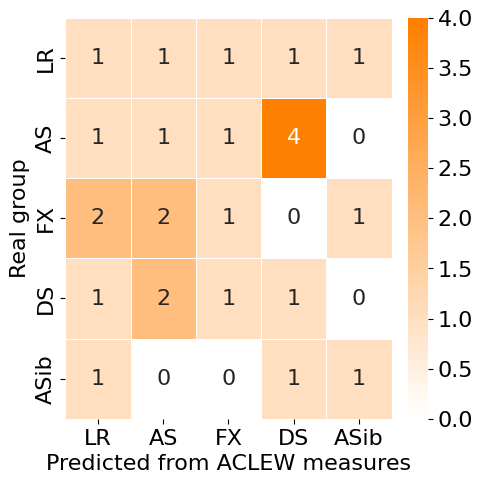

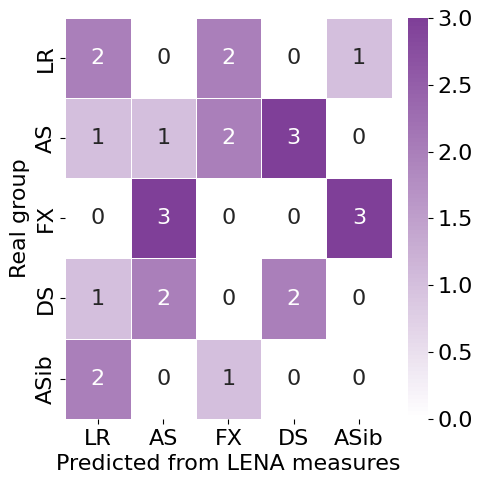

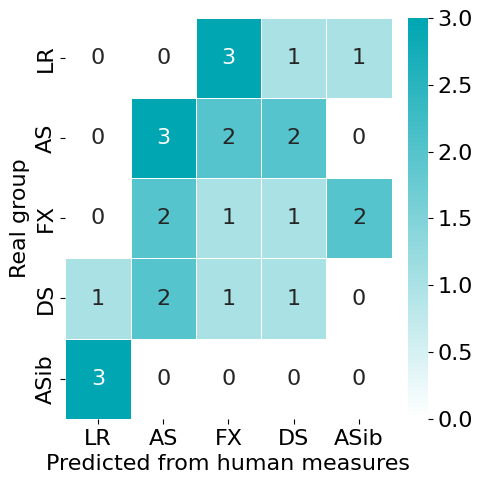

In [8]:
# Plot confusion matrix
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
import matplotlib
import numpy as np

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 16, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':4, 'lines.linewidth':1, 'xtick.labelsize': 16, 'ytick.labelsize': 16})

def plot_confusion_matrix(results, method_name, color):
    conf = results[method_name]['confusion_matrix']
    unique_labels = list(results[method_name]['unique_labels'])
    
    # Define orders and labels based on number of classes
    if len(unique_labels) == 5:  # five groups case
        order = ['low_risk', 'angelman_syndrome', 'fragile_x_syndrome', 'down_syndrome', 'autism_sibling']
        labels = ['LR', 'AS', 'FX', 'DS', 'ASib']
    elif len(unique_labels) == 3:  # three groups case
        order = ['low_risk', 'autism_sibling', 'other']
        labels = ['LR', 'ASib', 'Neurogen']
    
    # Reorder the confusion matrix
    idx = [unique_labels.index(o) for o in order]
    conf = conf[idx][:, idx]
    
    # Create custom colormap
    colors = ['white', color]
    n_bins = 100
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", colors, N=n_bins)
    
    cm = 1/2.54
    fig, ax = plt.subplots(1,1, figsize=(12*cm,12*cm), constrained_layout=True)
    
    sn.heatmap(conf, annot=True, ax=ax, fmt="d", linewidth=.5, 
               vmin=0, vmax=conf.max(), cmap=cmap)
    
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Real group')
    ax.set_xlabel(f'Predicted from {method_name} measures')
    
# Plot for each method with correct colors
colors = {
    'ACLEW': '#FF7F00',  # orange
    'LENA': '#7F3F98',   # purple
    'human': '#00A6B2'   # teal
}

for method, color in colors.items():
    plot_confusion_matrix(results, method, color)
    plt.savefig(f'/home/engaclew/neurogen/figures/diagnostic_classifiers/{method}_classifier.png', dpi=300)
    plt.show()

In [88]:
# Try decision trees
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_measures(X, y, name, feature_names, group_classes=None):
    if group_classes == 'three_groups':
        y = y.copy()
        other_conditions = ['angelman', 'down', 'fragile_x']
        y[np.isin(y, other_conditions)] = 'other'
    
    loo = LeaveOneOut()
    scaler = StandardScaler()
    clf = DecisionTreeClassifier(max_depth=3, class_weight='balanced')  # Limit depth to prevent overfitting
    
    predictions = []
    true_labels = []
    all_importances = []  # Store feature importances from each fold
    
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        clf.fit(X_train_scaled, y_train)
        pred = clf.predict(X_test_scaled)
        
        predictions.append(pred[0])
        true_labels.append(y_test[0])
        all_importances.append(clf.feature_importances_)
    
    accuracy = accuracy_score(true_labels, predictions)
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    # Average feature importances across folds
    mean_importance = np.mean(all_importances, axis=0)
    feature_importance = dict(zip(feature_names, mean_importance))
    sorted_importance = dict(sorted(feature_importance.items(), 
                                  key=lambda x: x[1], 
                                  reverse=True))
    
    results[name] = {
        'accuracy': accuracy,
        'predictions': predictions,
        'true_labels': true_labels,
        'confusion_matrix': conf_matrix,
        'unique_labels': np.unique(y),
        'feature_importance': sorted_importance
    }
    
    return results[name]

# Run analysis for each measurement source
for df, name in [(aclew_measures, 'ACLEW'), 
                 (lena_measures, 'LENA'), 
                 (human_measures, 'human')]:
    features = df.drop(['group_id', 'child_id'], axis=1)
    feature_names = features.columns
    X = features.values
    labels = df['group_id'].values
    
    results[name] = evaluate_measures(X, labels, name, feature_names, group_classes=None)
    print(f'Done running {name}.')
    print(f"\nFeature importance for {name}:")
    for feature, imp in results[name]['feature_importance'].items():
        print(f"{feature}: {imp:.3f}")

Done running ACLEW.

Feature importance for ACLEW:
avg_voc_dur_chi: 0.467
wc_adu: 0.233
third_quart_pitch: 0.137
first_quart_pitch: 0.069
5s_CTC: 0.057
median_pitch: 0.026
CVC: 0.012
Done running LENA.

Feature importance for LENA:
avg_voc_dur_chi: 0.245
5s_CTC: 0.214
CVC: 0.208
third_quart_pitch: 0.129
first_quart_pitch: 0.077
wc_adu: 0.068
median_pitch: 0.059
Done running human.

Feature importance for human:
wc_adu: 0.322
avg_voc_dur_chi: 0.303
first_quart_pitch: 0.248
5s_CTC: 0.068
median_pitch: 0.030
CVC: 0.015
third_quart_pitch: 0.015


In [72]:


lena_measures = pd.read_csv(DATA_PATH / 'lena_measures_chunks.csv').fillna(0)
lena_measures['speechlike_pitch'] = lena_measures['speechlike_pitch'].apply(safe_eval)


In [89]:
for key, values in results.items():
    print(f"{key} acc = {values['accuracy']} ({values['accuracy']*len(values['predictions'])} correctly diagnosed)")

nb_groups = len(np.unique(values['predictions']))
chance_acc = 1/nb_groups
print(f"Chance-level acc = {chance_acc} ({len(values['predictions'])/nb_groups} correctly diagnosed)")

ACLEW acc = 0.11538461538461539 (3.0 correctly diagnosed)
LENA acc = 0.15384615384615385 (4.0 correctly diagnosed)
human acc = 0.15384615384615385 (4.0 correctly diagnosed)
Chance-level acc = 0.2 (5.2 correctly diagnosed)


In [95]:
def evaluate_measures(X, y, name, feature_names, group_classes=None, 
                     max_depth=3, min_samples_split=2, min_samples_leaf=1,
                     criterion='gini', splitter='best', max_features=None):
    if group_classes == 'three_groups':
        y = y.copy()
        other_conditions = ['angelman', 'down', 'fragile_x']
        y[np.isin(y, other_conditions)] = 'other'
    
    loo = LeaveOneOut()
    scaler = StandardScaler()
    clf = DecisionTreeClassifier(
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        splitter=splitter,
        max_features=max_features,
        class_weight='balanced'
    )
    
    predictions = []
    true_labels = []
    all_importances = []
    
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        clf.fit(X_train_scaled, y_train)
        pred = clf.predict(X_test_scaled)
        
        predictions.append(pred[0])
        true_labels.append(y_test[0])
        all_importances.append(clf.feature_importances_)
    
    accuracy = accuracy_score(true_labels, predictions)
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    mean_importance = np.mean(all_importances, axis=0)
    feature_importance = dict(zip(feature_names, mean_importance))
    sorted_importance = dict(sorted(feature_importance.items(), 
                                  key=lambda x: x[1], 
                                  reverse=True))
    
    results[name] = {
        'accuracy': accuracy,
        'predictions': predictions,
        'true_labels': true_labels,
        'confusion_matrix': conf_matrix,
        'unique_labels': np.unique(y),
        'feature_importance': sorted_importance
    }
    
    return results[name]

parameters = [
    # Try very restrictive splits but deeper trees
    {'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2},
    {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2},
    
    # Try combining different feature selection with entropy
    {'max_depth': 4, 'criterion': 'entropy', 'max_features': 0.7},  # use 70% of features
    {'max_depth': 5, 'criterion': 'entropy', 'max_features': 0.5},  # use 50% of features
    
    # Try random splitter with different depths
    {'max_depth': 4, 'splitter': 'random', 'max_features': 'log2'},
    {'max_depth': 5, 'splitter': 'random', 'max_features': 'sqrt'},
    
    # Try very shallow trees with less restrictions
    {'max_depth': 2, 'min_samples_split': 2, 'max_features': None},
    {'max_depth': 3, 'min_samples_split': 2, 'max_features': None}
]

for params in parameters:
    print(f"\nTrying parameters: {params}")
    for df, name in [(aclew_measures, 'ACLEW'), 
                     (lena_measures, 'LENA'), 
                     (human_measures, 'Human')]:
        features = df.drop(['group_id', 'child_id'], axis=1)
        feature_names = features.columns
        X = features.values
        labels = df['group_id'].values
        
        results[name] = evaluate_measures(X, labels, name, feature_names, **params)
        print(f"{name} acc = {results[name]['accuracy']} ({results[name]['accuracy']*26} correctly diagnosed)")
    print(f"Chance-level acc = {0.2} ({0.2*26} correctly diagnosed)")


Trying parameters: {'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2}
ACLEW acc = 0.11538461538461539 (3.0 correctly diagnosed)
LENA acc = 0.19230769230769232 (5.0 correctly diagnosed)
Human acc = 0.23076923076923078 (6.0 correctly diagnosed)
Chance-level acc = 0.2 (5.2 correctly diagnosed)

Trying parameters: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}
ACLEW acc = 0.15384615384615385 (4.0 correctly diagnosed)
LENA acc = 0.19230769230769232 (5.0 correctly diagnosed)
Human acc = 0.3076923076923077 (8.0 correctly diagnosed)
Chance-level acc = 0.2 (5.2 correctly diagnosed)

Trying parameters: {'max_depth': 4, 'criterion': 'entropy', 'max_features': 0.7}
ACLEW acc = 0.15384615384615385 (4.0 correctly diagnosed)
LENA acc = 0.2692307692307692 (7.0 correctly diagnosed)
Human acc = 0.23076923076923078 (6.0 correctly diagnosed)
Chance-level acc = 0.2 (5.2 correctly diagnosed)

Trying parameters: {'max_depth': 5, 'criterion': 'entropy', 'max_features': 0.5}
ACL

In [33]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import relativedelta
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager
import ast

DATA_PATH = Path('/home/engaclew/neurogen')

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
lena_measures = pd.read_csv(DATA_PATH / 'lena_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Compute age and retrieve group_id information
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'date_iso', 'recording_filename', 'child_sex', 'child_dob']]
def diff_month(row):
    d1 = datetime.strptime(row['date_iso'], '%Y-%m-%d')
    d2 = datetime.strptime(row['child_dob'], '%Y-%m-%d')
    return (d1.year - d2.year) * 12 + d1.month - d2.month
recordings_data['age'] = recordings_data.apply(lambda row: diff_month(row), axis=1)

aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
lena_measures = lena_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')

# Merge pitch from speech-like and non-speech-like vocalizatiojns
def clean_pitch_concatenation(df):
    def safe_eval(x):
        if pd.isna(x):
            return []
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []
    df['speechlike_pitch'] = df['speechlike_pitch'].apply(safe_eval)
    df['nonspeechlike_pitch'] = df['nonspeechlike_pitch'].apply(safe_eval)
    df['pitch'] = df.apply( lambda row: row['speechlike_pitch'] + row['nonspeechlike_pitch'],  axis=1)
    return df
    
aclew_measures = clean_pitch_concatenation(aclew_measures)
lena_measures = clean_pitch_concatenation(lena_measures)
human_measures = clean_pitch_concatenation(human_measures)

# Compute CVC
def compute_CVC(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    return data

aclew_measures = compute_CVC(aclew_measures)
human_measures = compute_CVC(human_measures)

# Group per child
def group_clips(df):
    
    # Define aggregation rules for each column
    agg_rules = {
        'group_id': 'first',
        'child_id': 'first',
        'avg_voc_dur_chi': 'mean',
        'CVC': 'sum',
        'wc_adu': 'sum',
        '5s_CTC': 'sum',
        'speechlike_pitch': 'sum',
        'nonspeechlike_pitch': 'sum'
    }
    
    # Group by recording_filename and apply aggregations
    grouped = df.groupby('recording_filename').agg(agg_rules).reset_index()
    
    return grouped

aclew_measures = group_clips(aclew_measures)
lena_measures = group_clips(lena_measures)
human_measures = group_clips(human_measures)
human_measures

,recording_filename,group_id,child_id,avg_voc_dur_chi,CVC,wc_adu,5s_CTC,speechlike_pitch,nonspeechlike_pitch
0,20180808_111213_024881.wav,low_risk,2761,590.928529,151,309,13,"[247.84825319432744, 251.1031191922398, 229.59...",[366.13016378100906]
1,20180809_181624_025481.wav,low_risk,2781,642.662159,264,1139,201,"[337.4150278858197, 421.87055870285224, 309.91...","[429.6569717115748, 536.5033344452053, 381.644..."
2,20180906_131431_024882.wav,down_syndrome,3591,569.145675,157,1096,85,"[295.15866376379813, 270.6225060791767, 273.01...",[]
3,20181218_132113_024879.wav,angelman_syndrome,3131,390.908477,146,1214,141,"[408.4894364135654, 575.9143756551167, 254.869...",[290.11177304509465]
4,20190307_091344_022872.wav,down_syndrome,3951,577.021080,195,659,66,"[343.8137701073527, 378.9209649634173, 339.109...","[554.9726625967936, 501.9604546054814, 404.338..."
5,20190618_135122_024883.wav,low_risk,5011,585.713525,46,598,104,"[282.93940125421204, 287.0312136166218, 288.93...","[407.3220899626382, 384.77576931064533, 403.22..."
6,20190828_145547_024884_2.wav,angelman_syndrome,5061,776.673511,157,1412,201,"[277.9320392356493, 491.6403986655598, 280.711...",[384.60730675415857]
7,20201104_094551_024882_1.wav,down_syndrome,3871,418.670185,248,914,190,"[277.43953555200005, 329.31633640733867, 420.9...",[433.32221049351637]
8,20210127_103244_024879_1.wav,angelman_syndrome,5461,469.933283,51,781,20,"[545.2705167642991, 387.81421036281546, 369.23...","[369.3373654608002, 361.57842596194575]"
9,20210318_114509_043298.wav,angelman_syndrome,5961,348.267857,32,910,28,"[377.06353436294785, 399.597950671351, 492.753...",[365.88162417374986]


/tmp/ipykernel_24601/1543146153.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{label}\nn={group_sizes[label]}' for label in present_groups])


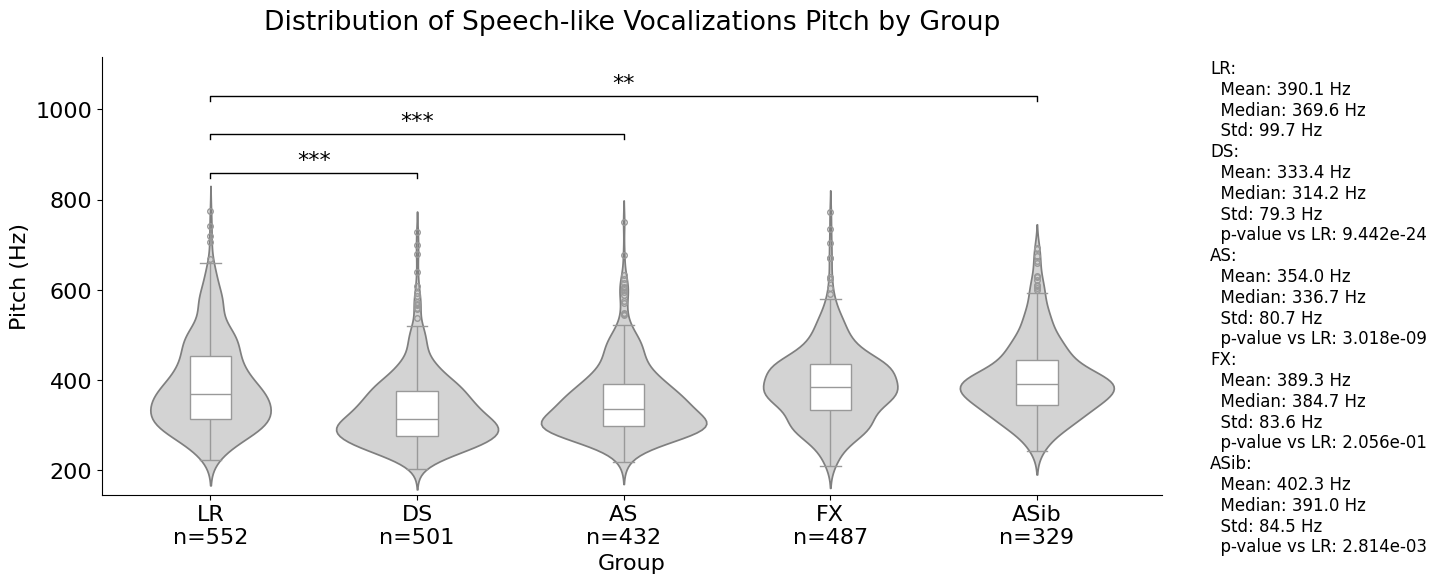

/tmp/ipykernel_24601/1543146153.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{label}\nn={group_sizes[label]}' for label in present_groups])


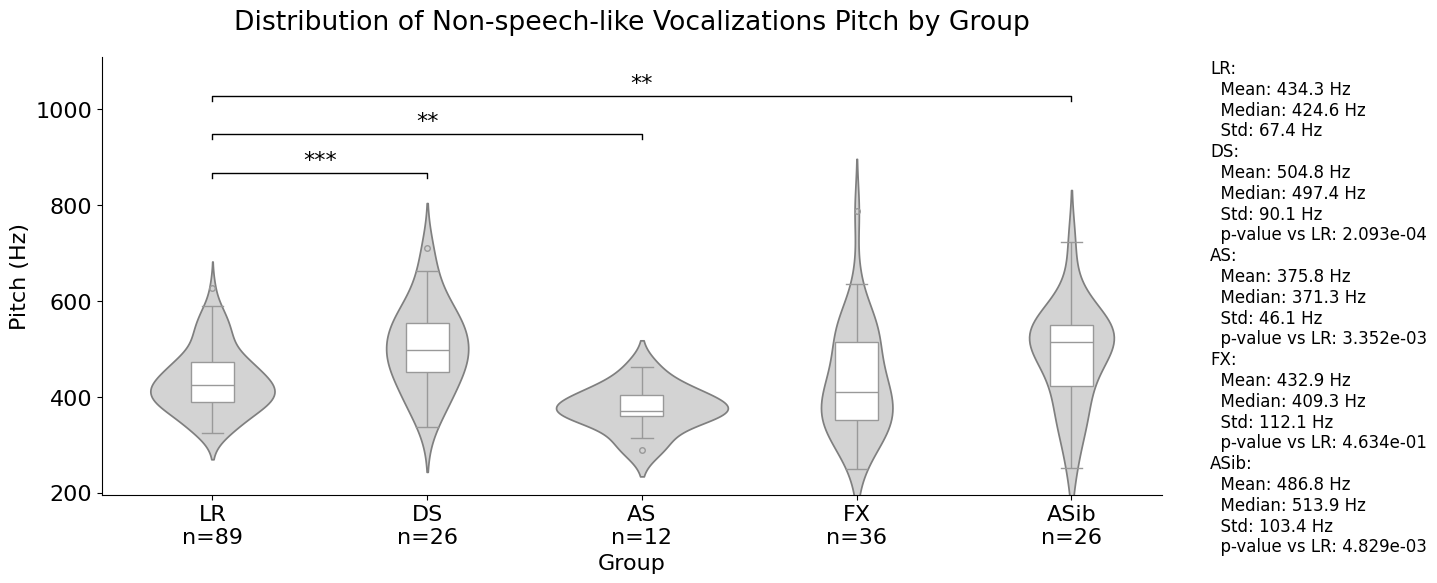

/tmp/ipykernel_24601/1543146153.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{label}\nn={group_sizes[label]}' for label in present_groups])


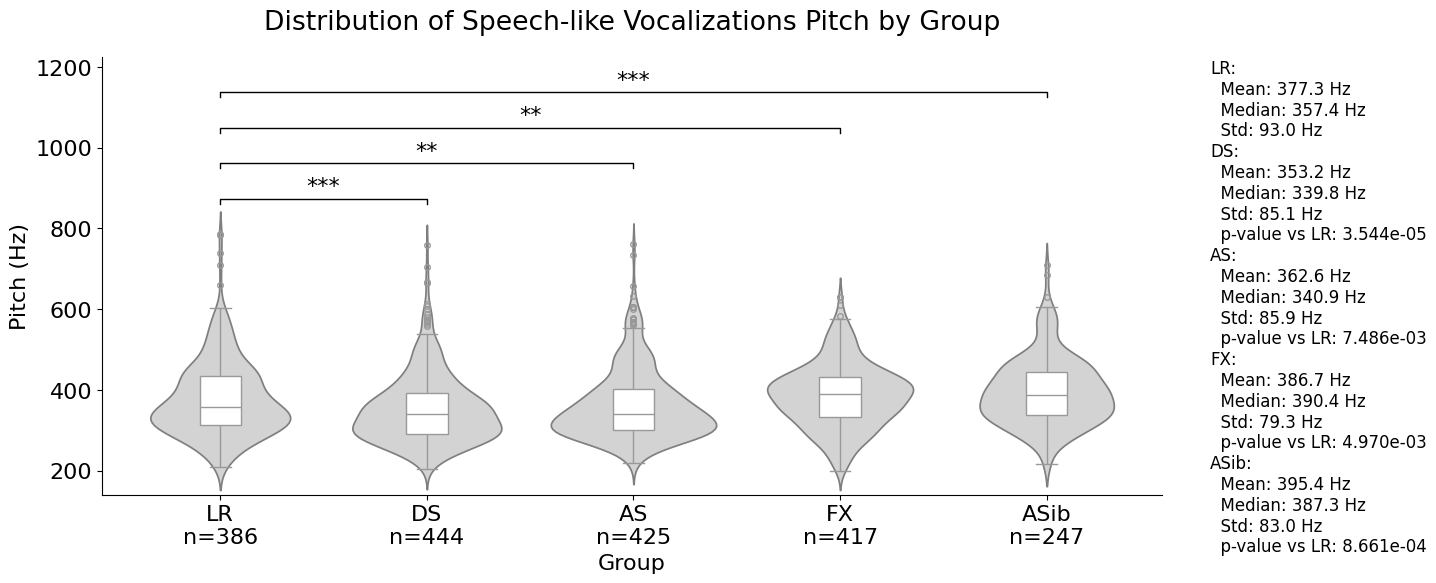

/tmp/ipykernel_24601/1543146153.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{label}\nn={group_sizes[label]}' for label in present_groups])


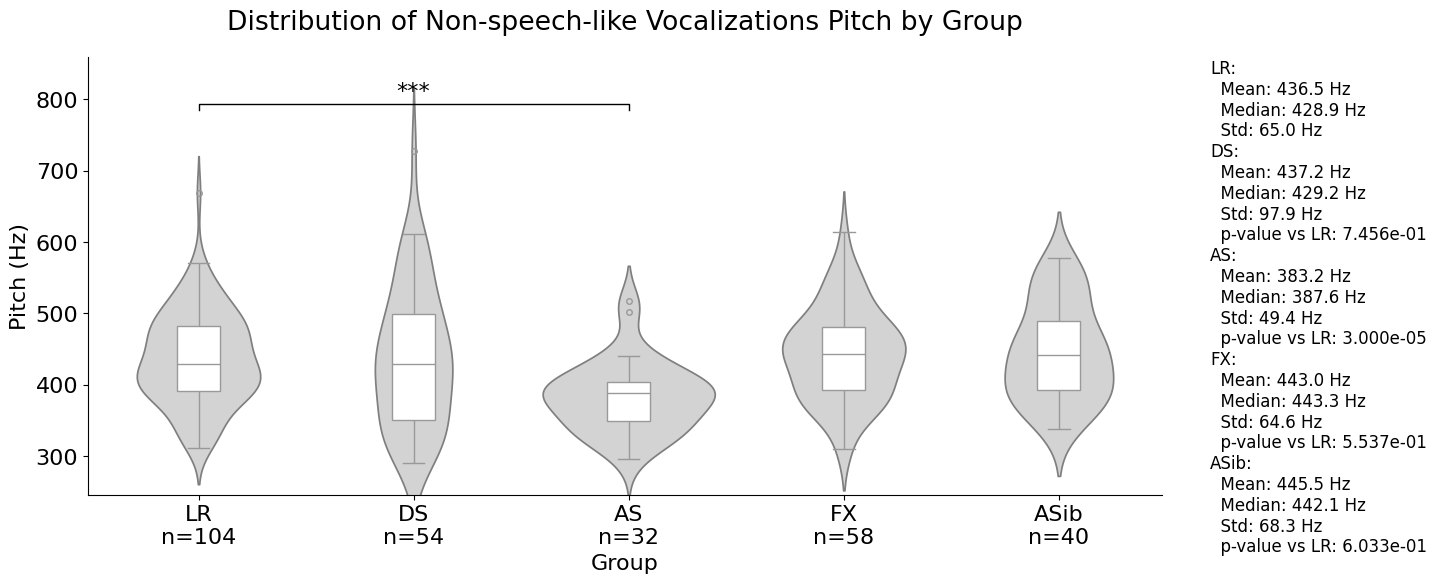

/tmp/ipykernel_24601/1543146153.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{label}\nn={group_sizes[label]}' for label in present_groups])


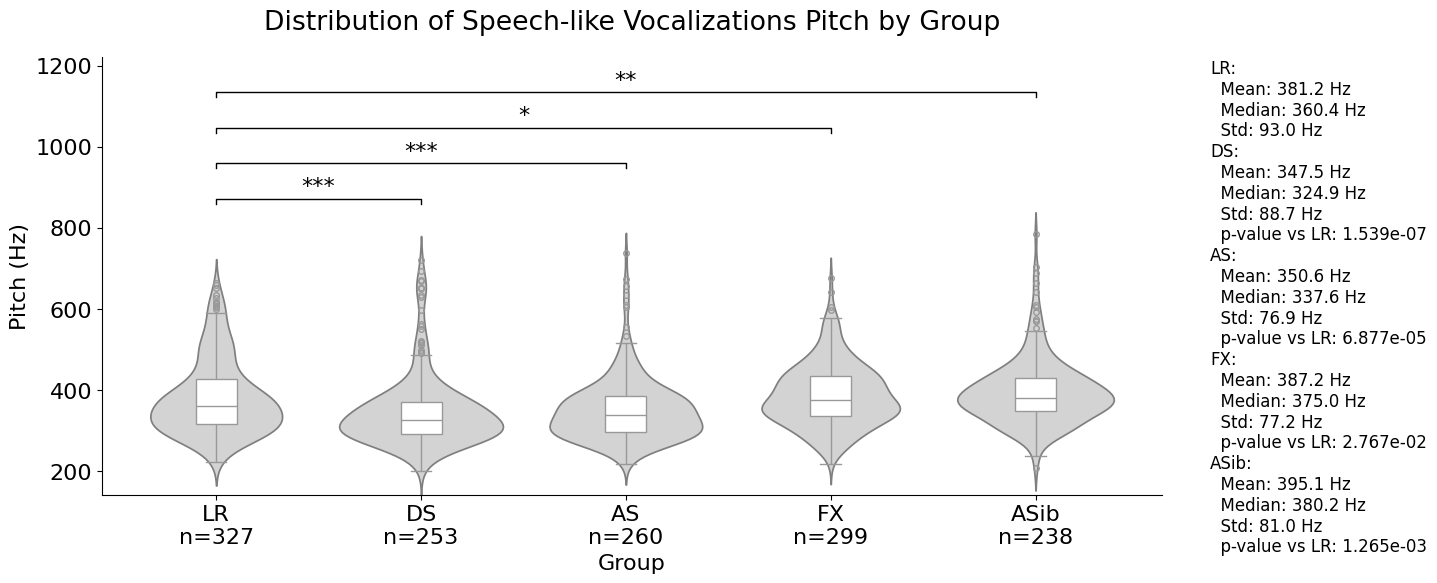

/tmp/ipykernel_24601/1543146153.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{label}\nn={group_sizes[label]}' for label in present_groups])


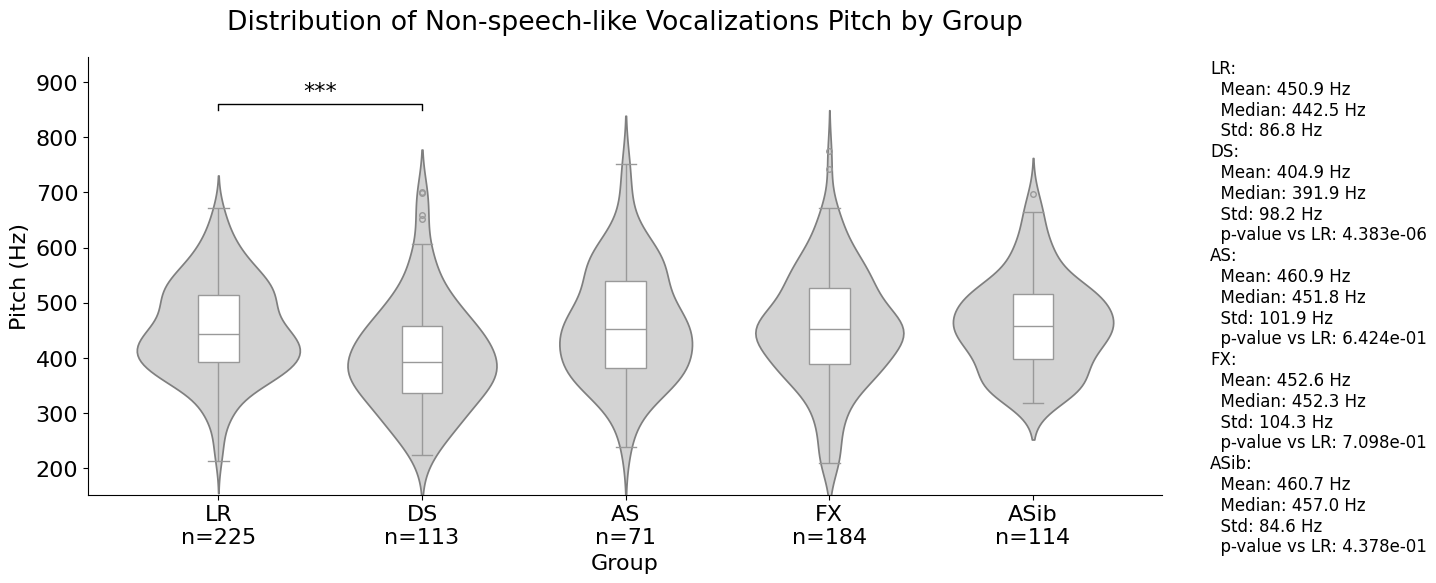

In [55]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def plot_pitch_distribution(df, pitch_type='speechlike_pitch', figsize=(12, 6), 
                          violin=True, box=True, points=False):
    """
    Plot the distribution of pitch values across groups with significance testing against low_risk group.
    """    
    # Define group label mapping
    group_labels = {
        'low_risk': 'LR',
        'down_syndrome': 'DS',
        'angelman_syndrome': 'AS',
        'fragile_x_syndrome': 'FX',
        'autism_sibling': 'ASib'
    }
    
    # Create a long-format DataFrame for plotting
    plot_data = []
    for idx, row in df.iterrows():
        pitches = row[pitch_type]
        if pitches and hasattr(pitches, '__iter__'):
            plot_data.extend([
                {'group_id': group_labels.get(row['group_id'], str(row['group_id'])),
                 'pitch': float(pitch)}
                for pitch in pitches
                if pitch is not None
            ])
    
    plot_df = pd.DataFrame(plot_data)
    
    if plot_df.empty:
        raise ValueError(f"No valid pitch data found in column '{pitch_type}'")
    
    # Get the actual groups present in the data
    present_groups = sorted(plot_df['group_id'].unique(),
                          key=lambda x: ['LR', 'DS', 'AS', 'FX', 'ASib'].index(x) 
                          if x in ['LR', 'DS', 'AS', 'FX', 'ASib'] else float('inf'))
    
    # Create categorical type only for groups that are present
    plot_df['group_id'] = pd.Categorical(plot_df['group_id'], 
                                       categories=present_groups, 
                                       ordered=True)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if violin:
        sns.violinplot(data=plot_df, x='group_id', y='pitch', 
                      color='lightgray', inner=None, ax=ax)
    
    if box:
        sns.boxplot(data=plot_df, x='group_id', y='pitch',
                   width=0.2, color='white', ax=ax)
    
    if points:
        sns.stripplot(data=plot_df, x='group_id', y='pitch',
                     size=2, color='black', alpha=0.1, ax=ax)
    
    # Add sample sizes below group labels
    group_sizes = plot_df['group_id'].value_counts().sort_index()
    ax.set_xticklabels([f'{label}\nn={group_sizes[label]}' for label in present_groups])
    
    # Perform statistical tests against LR group
    lr_data = plot_df[plot_df['group_id'] == 'LR']['pitch']
    y_max = plot_df['pitch'].max()
    y_range = plot_df['pitch'].max() - plot_df['pitch'].min()
    
    stats_results = {}
    for group in present_groups:
        if group != 'LR':
            group_data = plot_df[plot_df['group_id'] == group]['pitch']
            stat, p_value = stats.mannwhitneyu(lr_data, group_data, alternative='two-sided')
            stats_results[group] = p_value
            
            # Add significance stars
            stars = ''
            if p_value < 0.001:
                stars = '***'
            elif p_value < 0.01:
                stars = '**'
            elif p_value < 0.05:
                stars = '*'
                
            if stars:
                # Get x-coordinates of the groups
                lr_x = present_groups.index('LR')
                group_x = present_groups.index(group)
                
            # Only draw bars and stars if result is significant (p < 0.05)
            if p_value < 0.05:
                # Get index among significant results for spacing
                sig_groups = [g for g in present_groups if g != 'LR' and 
                            stats.mannwhitneyu(lr_data, 
                                             plot_df[plot_df['group_id'] == g]['pitch'], 
                                             alternative='two-sided')[1] < 0.05]
                current_sig_idx = sig_groups.index(group)
                
                # Calculate height based on position among significant results
                bar_height = y_max + y_range * (0.15 + current_sig_idx * 0.15)
                
                # Draw the connecting lines
                plt.plot([lr_x, lr_x, group_x, group_x], 
                        [bar_height-y_range*0.02, bar_height, bar_height, bar_height-y_range*0.02],
                        color='black', linewidth=1)
                
                # Add stars - slightly above the bar
                plt.text((lr_x + group_x)/2, bar_height + y_range*0.01, 
                        stars, ha='center', va='bottom')
    
    # Customize the plot
    title = 'Distribution of Speech-like Vocalizations Pitch by Group' if pitch_type == 'speechlike_pitch' else 'Distribution of Non-speech-like Vocalizations Pitch by Group'
    plt.title(title)
    plt.xlabel('Group')
    plt.ylabel('Pitch (Hz)')
    
    # Add summary statistics and p-values as text
    stats_text = ''
    for group in present_groups:
        group_data = plot_df[plot_df['group_id'] == group]['pitch']
        stats_text += f'\n{group}:\n'
        stats_text += f'  Mean: {group_data.mean():.1f} Hz\n'
        stats_text += f'  Median: {group_data.median():.1f} Hz\n'
        stats_text += f'  Std: {group_data.std():.1f} Hz'
        if group != 'LR' and group in stats_results:
            stats_text += f'\n  p-value vs LR: {stats_results[group]:.3e}'
    
    plt.figtext(1.02, 0.5, stats_text, 
                fontsize=12, va='center')
    
    # Get number of significant comparisons for plot height
    num_sig_comparisons = len([g for g in present_groups if g != 'LR' and 
                             stats.mannwhitneyu(plot_df[plot_df['group_id'] == 'LR']['pitch'],
                                              plot_df[plot_df['group_id'] == g]['pitch'],
                                              alternative='two-sided')[1] < 0.05])
    
    # Adjust plot height based on number of significant bars
    plt.ylim(plot_df['pitch'].min() - y_range*0.1, 
             y_max + y_range*(0.15 + num_sig_comparisons * 0.15))
    
    # Adjust layout to prevent title overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make more room for title
    
    # Move title up
    ax.set_title(title, pad=20)
    return fig

fig = plot_pitch_distribution(human_measures, pitch_type='speechlike_pitch', violin=True, box=True, points=False)
plt.savefig('/home/engaclew/neurogen/figures/pitch/human_speechlike_pitch.png', dpi=300, bbox_inches='tight')
plt.show()


fig = plot_pitch_distribution(human_measures, pitch_type='nonspeechlike_pitch', violin=True, box=True, points=False)
plt.savefig('/home/engaclew/neurogen/figures/pitch/human_nonspeechlike_pitch.png', dpi=300, bbox_inches='tight')
plt.show()


fig = plot_pitch_distribution(aclew_measures, pitch_type='speechlike_pitch', violin=True, box=True, points=False)
plt.savefig('/home/engaclew/neurogen/figures/pitch/aclew_speechlike_pitch.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_pitch_distribution(aclew_measures, pitch_type='nonspeechlike_pitch', violin=True, box=True, points=False)
plt.savefig('/home/engaclew/neurogen/figures/pitch/aclew_nonspeechlike_pitch.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_pitch_distribution(lena_measures, pitch_type='speechlike_pitch', violin=True, box=True, points=False)
plt.savefig('/home/engaclew/neurogen/figures/pitch/lena_speechlike_pitch.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_pitch_distribution(lena_measures, pitch_type='nonspeechlike_pitch', violin=True, box=True, points=False)
plt.savefig('/home/engaclew/neurogen/figures/pitch/lena_nonspeechlike_pitch.png', dpi=300, bbox_inches='tight')
plt.show()

In [66]:
idx=3
print(len(aclew_measures.iloc[idx]['speechlike_pitch']), aclew_measures.iloc[idx]['CVC'])
print(len(human_measures.iloc[idx]['speechlike_pitch']), human_measures.iloc[idx]['CVC'])
print(len(lena_measures.iloc[idx]['speechlike_pitch']), lena_measures.iloc[idx]['CVC'])

75 102
54 146
65 111.0
